<a href="https://www.kaggle.com/code/neerajgangiti4120/plant-species?scriptVersionId=250450238" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
train_path='/kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder'
test_path='/kaggle/input/plants-type-datasets/split_ttv_dataset_type_of_plants/Train_Set_Folder'

In [3]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [4]:
train_ds = ImageFolder(root=train_path, transform=train_transforms)
test_ds = ImageFolder(root=test_path, transform= test_transforms)

In [5]:
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=1000)

In [6]:
class CNN(torch.nn.Module): 
    def __init__(self):
        super().__init__()
        
        #ConvLayer 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )  
        #ConvLayer 2
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #ConvLayer 3
        self.conv3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #ConvLayer 4
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        #Global Adaptive Pool
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))
        #Dropout
        self.dropout = nn.Dropout(0.1)
        #fully connected layer
        self.fc = nn.Linear(128, 256)
        self.output = nn.Linear(256, 30)
    
        
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.global_pool(x)
        
        #Flatten
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = F.relu(self.fc(x))

        return self.output(x)

In [7]:
#Accessing gpu
def set_device():
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return torch.device(dev)

In [8]:
dev = set_device()
model = CNN().to(dev)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, weight_decay=0.0001)

In [9]:
train_losses=[]
train_accuracies=[]
test_losses=[]
test_accuracies=[]
filtered_preds=[]
filtered_labels=[]
all_preds=[]
all_labels=[]

In [10]:
#training the model
def train_nn(model, train_loader, test_loader, criterion, optimizer, n_epochs):
  device = set_device()
  best_acc = 0

  for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    train_correct = 0
    train_total = 0
    best_acc = 0

    for images, labels in train_loader:
      images = images.to(device)
      labels = labels.to(device)
      train_total += labels.size(0)

      optimizer.zero_grad()
      outputs = model(images)
      predicted = torch.argmax(outputs, 1)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_correct += (labels==predicted).sum().item()

    train_losses.append(train_loss/len(train_loader))
    train_accuracies.append(100*train_correct/train_total)
    
    print(f"Epoch: {epoch +1} \n Training Accuracy: {100*train_correct/train_total:.2f}%, Loss: {train_loss/len(train_loader):.4f}")

    # get_predictions_and_labels(model, test_loader, device)
      
    test_acc = evaluate(model, test_loader)

    if(test_acc > best_acc):
      best_acc = test_acc
      save_checkpoint(model, epoch, optimizer, best_acc)
        
  plt.figure(figsize=(10, 4))
  plt.plot(train_losses, label="Training losses", color="red", marker="o")
  plt.plot(test_losses, label="Testing losses", color="green", marker="o")
  plt.xlabel('Epoch')
  plt.ylabel('Accuracies')
  plt.title('Training losses vs Testing losses')
  plt.legend()
  plt.grid(True)
  plt.show(block=False)
    
  plt.figure(figsize=(10, 4))
  plt.plot(train_accuracies, label="Traning Accuracies", color="red", marker="o")
  plt.plot(test_accuracies, label="Testing Accuracies", color="blue", marker="o")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracies")
  plt.title("Training accuracies vs Testing accuracies")
  plt.legend()
  plt.grid(True)
  plt.show(block=False)  

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
def evaluate(model, test_loader):
    model.eval()
    test_loss=0
    test_correct=0
    test_total=0
    device = set_device()
    
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            predicted = torch.argmax(outputs, 1)
            test_correct += (predicted == labels).sum().item()
            test_total += labels.size(0)
            test_loss += loss.item()
            all_preds.extend(predicted.cpu().numpy().tolist())
            all_labels.extend(labels.cpu().numpy().tolist())

    test_losses.append(test_loss/len(test_loader))
    test_accuracies.append(100*test_correct/test_total)
    epoch_acc = 100*test_correct/test_total
    
    print(f"Test Accuracy: {epoch_acc:.2f}%, Loss: {test_loss/len(test_loader):.4f}")
    return epoch_acc

In [12]:
def save_checkpoint(model, epoch, optimizer, best_acc):
    state={
        'epoch':epoch+1,
        'model':model.state_dict(),
        'best_accuracy':best_acc,
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, 'model_best_checkpoint.pth.tar')

In [13]:
#using Resnet18 pretrained model
import torchvision.models as models

resnet18_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in resnet18_model.parameters():
    param.requires_grad = False
for param in resnet18_model.layer4.parameters():
    param.requires_grad = True
num_ftrs = resnet18_model.fc.in_features
resnet18_model.fc = nn.Linear(num_ftrs, 30)
resnet18_model = resnet18_model.to(dev)

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet18_model.parameters()), lr = 0.001)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 236MB/s]


Epoch: 1 
 Training Accuracy: 81.95%, Loss: 0.5946
Test Accuracy: 80.38%, Loss: 0.6585
Epoch: 2 
 Training Accuracy: 90.79%, Loss: 0.2728
Test Accuracy: 83.42%, Loss: 0.5245
Epoch: 3 
 Training Accuracy: 93.47%, Loss: 0.1966
Test Accuracy: 82.60%, Loss: 0.5873
Epoch: 4 
 Training Accuracy: 94.32%, Loss: 0.1672
Test Accuracy: 81.43%, Loss: 0.6302
Epoch: 5 
 Training Accuracy: 96.09%, Loss: 0.1142
Test Accuracy: 89.69%, Loss: 0.3424
Epoch: 6 
 Training Accuracy: 95.65%, Loss: 0.1271
Test Accuracy: 90.05%, Loss: 0.3138
Epoch: 7 
 Training Accuracy: 96.65%, Loss: 0.1068
Test Accuracy: 83.85%, Loss: 0.6054
Epoch: 8 
 Training Accuracy: 97.00%, Loss: 0.0902
Test Accuracy: 86.01%, Loss: 0.5462
Epoch: 9 
 Training Accuracy: 96.86%, Loss: 0.0946
Test Accuracy: 88.97%, Loss: 0.3946
Epoch: 10 
 Training Accuracy: 97.27%, Loss: 0.0831
Test Accuracy: 88.45%, Loss: 0.4434


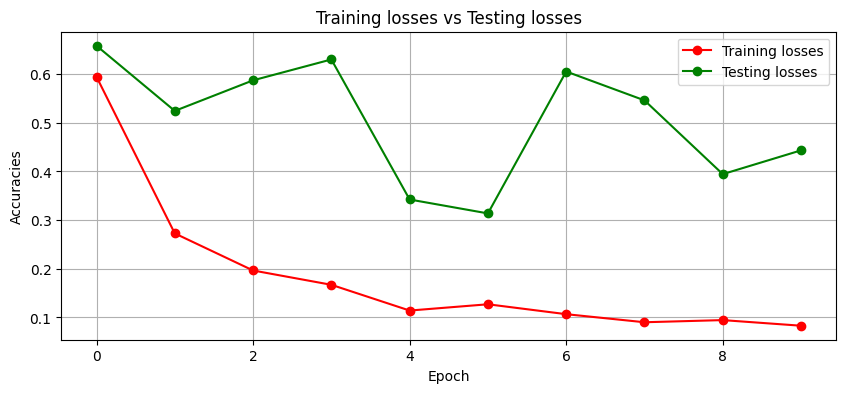

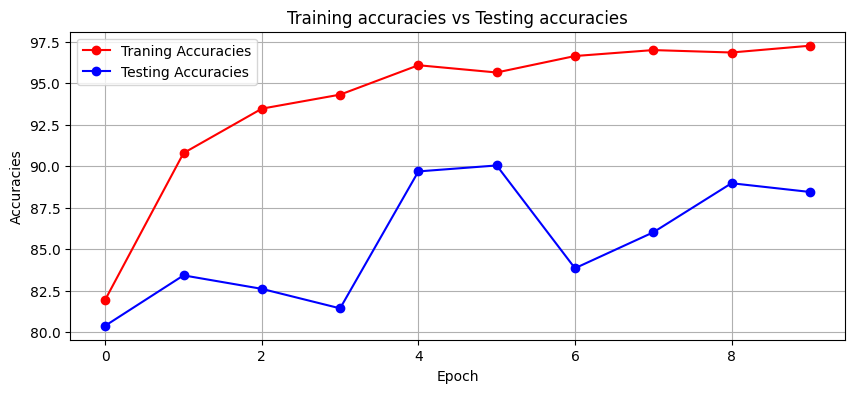

In [14]:
train_nn(resnet18_model, train_loader, test_loader, criterion, optimizer, 10)

In [15]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, digits=4))

              precision    recall  f1-score   support

           0     0.7280    0.9713    0.8323      7990
           1     0.9295    0.9383    0.9339      7990
           2     0.9639    0.7292    0.8303      7990
           3     0.6449    0.7582    0.6970      7990
           4     0.9000    0.9372    0.9182      7990
           5     0.7762    0.9120    0.8386      7990
           6     0.9825    0.9300    0.9556      7990
           7     0.9332    0.9355    0.9343      8000
           8     0.9948    0.4800    0.6475      7990
           9     0.9931    0.8079    0.8910      7990
          10     0.9134    0.9050    0.9092      7990
          11     0.7131    0.9282    0.8066      7990
          12     0.8431    0.9101    0.8754      7990
          13     0.9042    0.8683    0.8859      7990
          14     0.9034    0.9269    0.9150      7990
          15     0.9454    0.6874    0.7960      7990
          16     0.6106    0.8070    0.6952      7990
          17     0.9486    

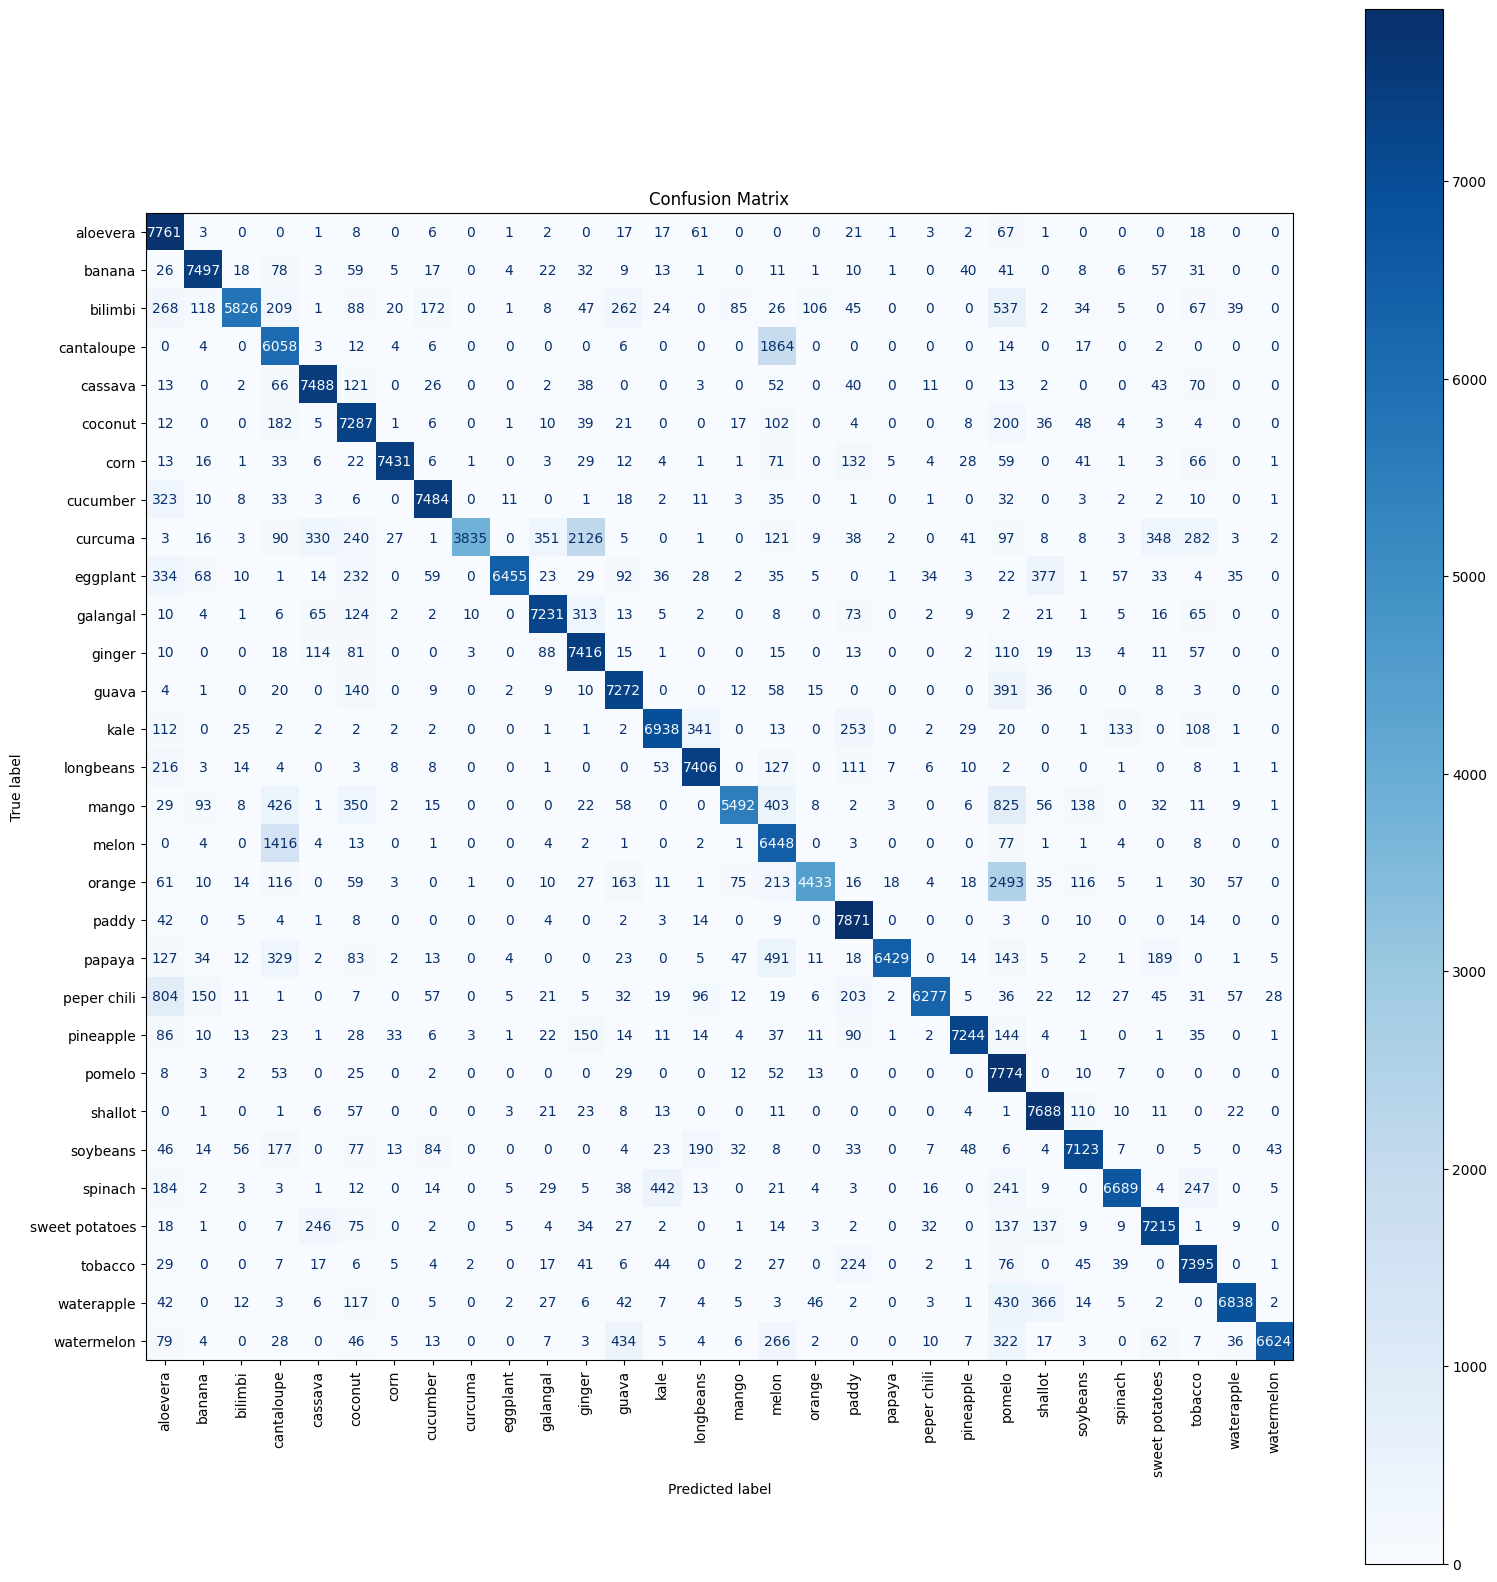

In [16]:
cm = confusion_matrix(all_labels, all_preds)
labels = test_ds.classes
fig, ax = plt.subplots(figsize=(16, 16))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=labels)
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.tight_layout()
plt.title("Confusion Matrix")
plt.show()